# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.40KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

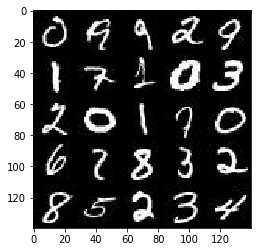

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

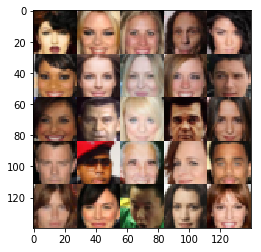

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    
    alpha = 0.2 

    x = images

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    
    # temp to get it work
    alpha = 0.2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        # resize to 28x28x3
        image_size_required = (28, 28)
        logits_right_size = tf.image.resize_images(logits, image_size_required)
        
        out = tf.tanh(logits_right_size)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    # 4.3 gan_mnist/Intro_to_GANs_Solution.ipynb - smooth
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # code ref
    # 4.5 dcgan-svhn/DCGAN.ipynb
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # loop variables
    steps = 0    
    print_every = 10
    show_every = 100
    
    # real, fake, learning rate
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # input, learning rate
    input_real, input_z, l_r = model_inputs(image_width, image_height, image_channels, z_dim)
    # loss                                
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    # optimizer
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # batch_images is real images                
                # batch_z is fake images, random noise 
                
                # input_real is real input tensor - function parameter
                # input_z is fake input tensor - function parameter
                
                # Run optimizers                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     l_r: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z, 
                                                     l_r: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    
                    n_images = 25 # batch_size
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
        
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.5495
Epoch 1/2... Discriminator Loss: 3.0248... Generator Loss: 0.0872
Epoch 1/2... Discriminator Loss: 2.1905... Generator Loss: 0.2338
Epoch 1/2... Discriminator Loss: 1.6890... Generator Loss: 0.3626
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.5447
Epoch 1/2... Discriminator Loss: 1.3061... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.6342... Generator Loss: 0.3616
Epoch 1/2... Discriminator Loss: 1.7530... Generator Loss: 0.3133
Epoch 1/2... Discriminator Loss: 1.7120... Generator Loss: 0.3424
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.4283


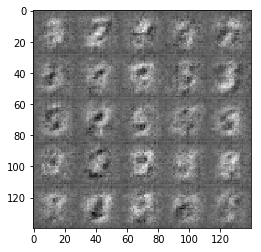

Epoch 1/2... Discriminator Loss: 1.4616... Generator Loss: 0.4446
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.5080
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.4436
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.4975
Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.5812
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.1715... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 0.5364


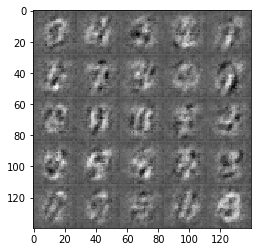

Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 2.4878
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 2.1807
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 2.0312
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 2.0487
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 2.3126
Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 2.1203
Epoch 1/2... Discriminator Loss: 0.7873... Generator Loss: 2.2607
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.9821
Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 1.9042


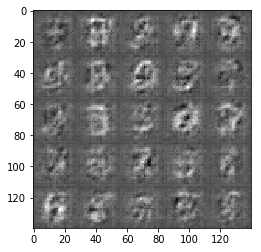

Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 2.9704
Epoch 1/2... Discriminator Loss: 0.6832... Generator Loss: 1.5800
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 0.5336... Generator Loss: 2.3687
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 1.9816
Epoch 1/2... Discriminator Loss: 0.6143... Generator Loss: 3.0794
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 3.0805
Epoch 1/2... Discriminator Loss: 0.6432... Generator Loss: 1.8331
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 0.4374


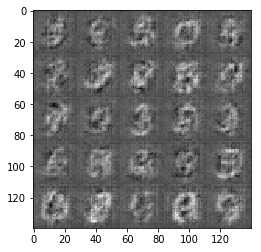

Epoch 1/2... Discriminator Loss: 0.7220... Generator Loss: 1.2110
Epoch 1/2... Discriminator Loss: 1.1239... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 3.4129
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 2.1960
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 2.7699
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.2256
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 0.9733
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.4340
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 1.0734


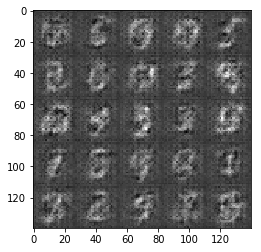

Epoch 1/2... Discriminator Loss: 0.5869... Generator Loss: 2.1541
Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 2.9995
Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.8100
Epoch 1/2... Discriminator Loss: 0.7445... Generator Loss: 3.0396
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 2.3077
Epoch 1/2... Discriminator Loss: 0.6660... Generator Loss: 1.5502
Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 1.6544
Epoch 1/2... Discriminator Loss: 0.6433... Generator Loss: 1.9576
Epoch 1/2... Discriminator Loss: 0.5917... Generator Loss: 1.9362
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.5147


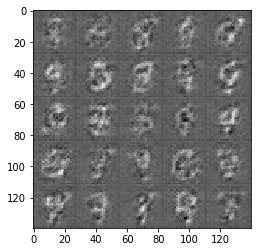

Epoch 1/2... Discriminator Loss: 0.6069... Generator Loss: 1.8603
Epoch 1/2... Discriminator Loss: 0.6113... Generator Loss: 1.9662
Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 2.8210
Epoch 1/2... Discriminator Loss: 0.6533... Generator Loss: 2.4086
Epoch 1/2... Discriminator Loss: 0.6204... Generator Loss: 1.8250
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 3.2316
Epoch 1/2... Discriminator Loss: 0.5751... Generator Loss: 1.8870
Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 0.8416
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 0.5641... Generator Loss: 1.7853


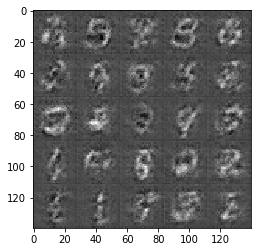

Epoch 1/2... Discriminator Loss: 0.5864... Generator Loss: 1.6553
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 3.1841
Epoch 1/2... Discriminator Loss: 0.6071... Generator Loss: 1.8680
Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 1.5298
Epoch 1/2... Discriminator Loss: 0.6409... Generator Loss: 1.4421
Epoch 1/2... Discriminator Loss: 1.3953... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 2.1785
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 2.5497
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 2.6482
Epoch 1/2... Discriminator Loss: 0.5558... Generator Loss: 2.5945


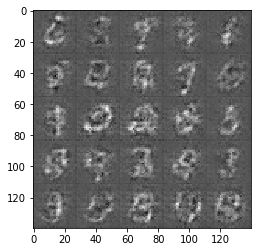

Epoch 1/2... Discriminator Loss: 0.5068... Generator Loss: 2.4459
Epoch 1/2... Discriminator Loss: 0.4926... Generator Loss: 2.5048
Epoch 1/2... Discriminator Loss: 0.4775... Generator Loss: 2.4792
Epoch 1/2... Discriminator Loss: 1.5268... Generator Loss: 0.4459
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 1.8684
Epoch 1/2... Discriminator Loss: 0.5500... Generator Loss: 1.8540
Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 1.8972
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 2.2464
Epoch 1/2... Discriminator Loss: 0.5288... Generator Loss: 1.8610


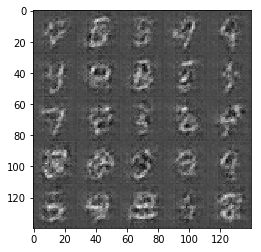

Epoch 1/2... Discriminator Loss: 0.5417... Generator Loss: 2.4837
Epoch 1/2... Discriminator Loss: 0.5278... Generator Loss: 1.9302
Epoch 1/2... Discriminator Loss: 0.4796... Generator Loss: 2.2286
Epoch 2/2... Discriminator Loss: 1.5200... Generator Loss: 3.5819
Epoch 2/2... Discriminator Loss: 0.6430... Generator Loss: 1.4942
Epoch 2/2... Discriminator Loss: 0.5527... Generator Loss: 1.9120
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 2.2216
Epoch 2/2... Discriminator Loss: 0.4979... Generator Loss: 2.1476
Epoch 2/2... Discriminator Loss: 0.5124... Generator Loss: 2.0791
Epoch 2/2... Discriminator Loss: 0.7479... Generator Loss: 1.1665


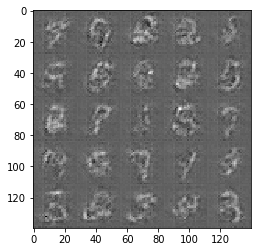

Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 1.5089
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 2.3680
Epoch 2/2... Discriminator Loss: 0.5165... Generator Loss: 3.7265
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 1.8281
Epoch 2/2... Discriminator Loss: 0.4875... Generator Loss: 2.0563
Epoch 2/2... Discriminator Loss: 0.4329... Generator Loss: 2.6143
Epoch 2/2... Discriminator Loss: 0.4139... Generator Loss: 2.8476
Epoch 2/2... Discriminator Loss: 0.3981... Generator Loss: 3.3307
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 3.2379
Epoch 2/2... Discriminator Loss: 1.7358... Generator Loss: 2.5120


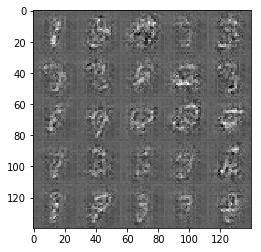

Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.9985
Epoch 2/2... Discriminator Loss: 0.6431... Generator Loss: 1.4891
Epoch 2/2... Discriminator Loss: 0.5773... Generator Loss: 2.0636
Epoch 2/2... Discriminator Loss: 0.5006... Generator Loss: 2.0639
Epoch 2/2... Discriminator Loss: 0.4336... Generator Loss: 2.6420
Epoch 2/2... Discriminator Loss: 0.4140... Generator Loss: 2.7320
Epoch 2/2... Discriminator Loss: 0.5071... Generator Loss: 3.1003
Epoch 2/2... Discriminator Loss: 0.4403... Generator Loss: 2.5445
Epoch 2/2... Discriminator Loss: 0.4016... Generator Loss: 2.9897
Epoch 2/2... Discriminator Loss: 0.3992... Generator Loss: 3.2035


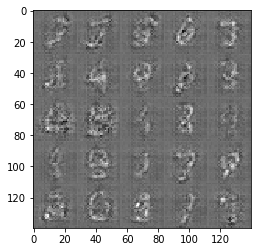

Epoch 2/2... Discriminator Loss: 0.4180... Generator Loss: 2.7742
Epoch 2/2... Discriminator Loss: 0.4245... Generator Loss: 3.5909
Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 2.3147
Epoch 2/2... Discriminator Loss: 0.4076... Generator Loss: 3.2497
Epoch 2/2... Discriminator Loss: 0.4855... Generator Loss: 2.2023
Epoch 2/2... Discriminator Loss: 0.4462... Generator Loss: 2.4964
Epoch 2/2... Discriminator Loss: 4.4963... Generator Loss: 5.3116
Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 1.5485
Epoch 2/2... Discriminator Loss: 0.5366... Generator Loss: 1.9515
Epoch 2/2... Discriminator Loss: 0.5120... Generator Loss: 1.9264


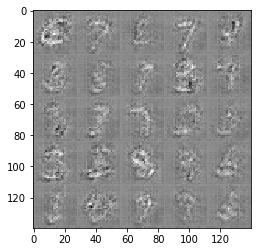

Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 2.6222
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 2.6431
Epoch 2/2... Discriminator Loss: 0.4109... Generator Loss: 3.0596
Epoch 2/2... Discriminator Loss: 0.4518... Generator Loss: 2.4205
Epoch 2/2... Discriminator Loss: 0.4023... Generator Loss: 3.3114
Epoch 2/2... Discriminator Loss: 0.5111... Generator Loss: 1.9243
Epoch 2/2... Discriminator Loss: 0.4168... Generator Loss: 3.0380
Epoch 2/2... Discriminator Loss: 0.4615... Generator Loss: 2.6319
Epoch 2/2... Discriminator Loss: 0.4287... Generator Loss: 2.5259
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 3.8375


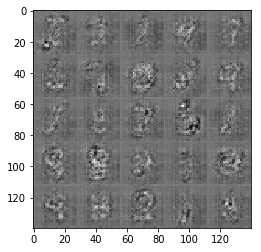

Epoch 2/2... Discriminator Loss: 0.4074... Generator Loss: 3.4177
Epoch 2/2... Discriminator Loss: 0.4436... Generator Loss: 2.8111
Epoch 2/2... Discriminator Loss: 0.4247... Generator Loss: 2.5696
Epoch 2/2... Discriminator Loss: 0.4950... Generator Loss: 2.0345
Epoch 2/2... Discriminator Loss: 1.5889... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.5125... Generator Loss: 0.4315
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.6191
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.3026
Epoch 2/2... Discriminator Loss: 0.4962... Generator Loss: 2.0923
Epoch 2/2... Discriminator Loss: 0.4243... Generator Loss: 2.8755


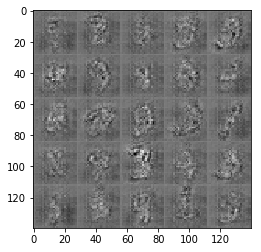

Epoch 2/2... Discriminator Loss: 0.4243... Generator Loss: 2.6959
Epoch 2/2... Discriminator Loss: 0.4467... Generator Loss: 2.5460
Epoch 2/2... Discriminator Loss: 0.5265... Generator Loss: 1.8680
Epoch 2/2... Discriminator Loss: 0.4307... Generator Loss: 3.1043
Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 2.4247
Epoch 2/2... Discriminator Loss: 0.4385... Generator Loss: 2.3719
Epoch 2/2... Discriminator Loss: 0.4722... Generator Loss: 2.1638
Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 2.1718
Epoch 2/2... Discriminator Loss: 0.3950... Generator Loss: 2.9915
Epoch 2/2... Discriminator Loss: 0.3688... Generator Loss: 4.0994


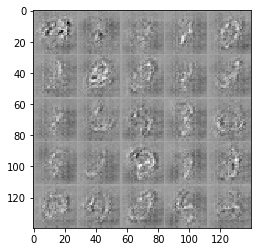

Epoch 2/2... Discriminator Loss: 0.4138... Generator Loss: 2.6694
Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 2.4078
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 2.4755
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 1.9987
Epoch 2/2... Discriminator Loss: 0.4549... Generator Loss: 2.3011
Epoch 2/2... Discriminator Loss: 0.4223... Generator Loss: 3.2418
Epoch 2/2... Discriminator Loss: 0.4077... Generator Loss: 3.0711
Epoch 2/2... Discriminator Loss: 0.4287... Generator Loss: 2.5969
Epoch 2/2... Discriminator Loss: 0.4615... Generator Loss: 2.2340
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 2.2732


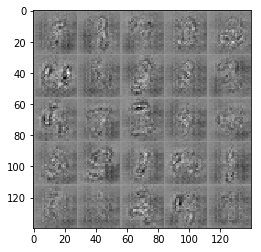

Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 2.5229
Epoch 2/2... Discriminator Loss: 0.3827... Generator Loss: 3.4244
Epoch 2/2... Discriminator Loss: 0.5074... Generator Loss: 1.9411
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 5.3298
Epoch 2/2... Discriminator Loss: 3.6817... Generator Loss: 0.0601
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.6172
Epoch 2/2... Discriminator Loss: 0.6244... Generator Loss: 1.5131
Epoch 2/2... Discriminator Loss: 0.4361... Generator Loss: 2.7376
Epoch 2/2... Discriminator Loss: 0.5436... Generator Loss: 1.8498
Epoch 2/2... Discriminator Loss: 0.4416... Generator Loss: 2.5084


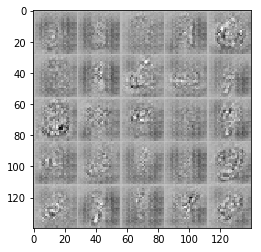

Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 2.4140
Epoch 2/2... Discriminator Loss: 0.4390... Generator Loss: 2.6434
Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 1.9012
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 1.9081
Epoch 2/2... Discriminator Loss: 0.5107... Generator Loss: 1.9378
Epoch 2/2... Discriminator Loss: 0.4123... Generator Loss: 2.8716
Epoch 2/2... Discriminator Loss: 0.4356... Generator Loss: 3.2795


In [45]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [ ]:
# The Generator Loss was once lower than Discriminator Loss, 
# But not at the end of training.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 11.8048
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 19.7176
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 5.3561
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 3.2480
Epoch 1/1... Discriminator Loss: 2.2538... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 6.0936
Epoch 1/1... Discriminator Loss: 3.6020... Generator Loss: 0.0938
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 7.0473
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.0235


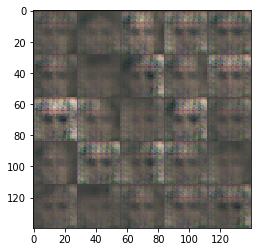

Epoch 1/1... Discriminator Loss: 3.4208... Generator Loss: 5.9487
Epoch 1/1... Discriminator Loss: 3.1031... Generator Loss: 5.4441
Epoch 1/1... Discriminator Loss: 1.8798... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.6429
Epoch 1/1... Discriminator Loss: 1.9635... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 1.6341... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.8831... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.8034


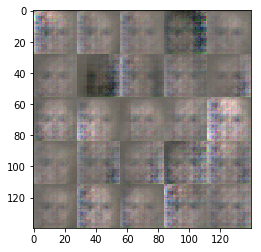

Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9145


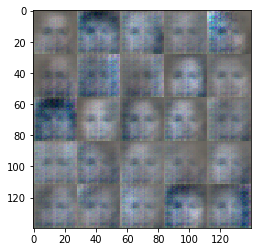

Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 2.1262... Generator Loss: 0.2155
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.5742


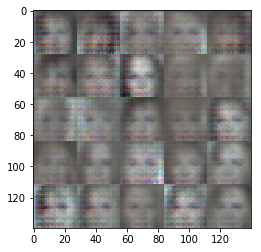

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.8280
Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 0.6251... Generator Loss: 2.0052
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.2156
Epoch 1/1... Discriminator Loss: 1.7986... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 1.1329
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 1.0009


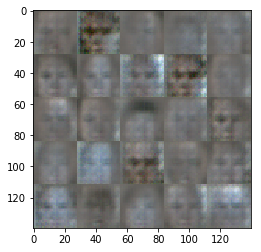

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.0802
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.4504


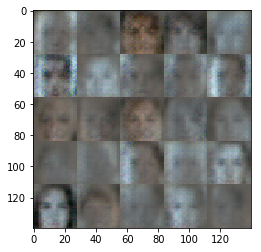

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.8023... Generator Loss: 3.6029
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.8359... Generator Loss: 0.2954
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5448


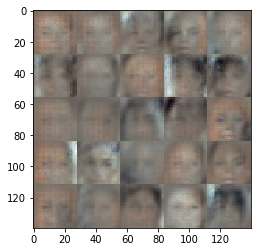

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 2.1545... Generator Loss: 0.2140
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 2.1494
Epoch 1/1... Discriminator Loss: 0.4937... Generator Loss: 3.6447
Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 4.1539


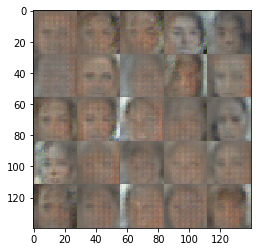

Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 3.2901
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 0.5394... Generator Loss: 2.8706
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.2185
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 4.9164
Epoch 1/1... Discriminator Loss: 1.9604... Generator Loss: 2.8965
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 3.9939


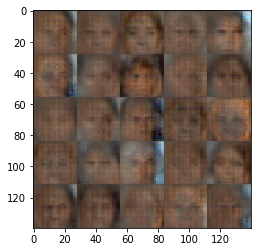

Epoch 1/1... Discriminator Loss: 0.5542... Generator Loss: 2.2813
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 2.5236
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.5520


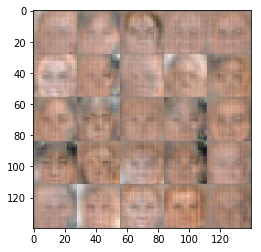

Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 2.4591
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 1.4300
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 2.9147... Generator Loss: 6.3822
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 1.1811


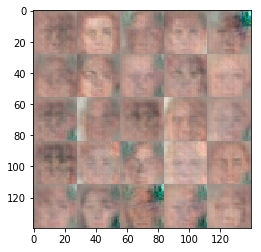

Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 0.4319... Generator Loss: 3.4732
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 2.1496
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 5.2628
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 3.0581
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 2.1160
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 2.4992
Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 2.3296


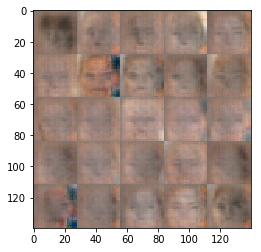

Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.7347
Epoch 1/1... Discriminator Loss: 1.6968... Generator Loss: 4.9127
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.6204
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 4.9324
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 1.2727
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 0.7849... Generator Loss: 3.0892
Epoch 1/1... Discriminator Loss: 0.5378... Generator Loss: 2.3357
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 2.0372


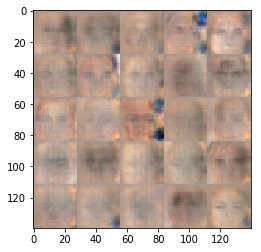

Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.2927
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 2.0991
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 0.7377... Generator Loss: 1.5855
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 3.0082
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.8346
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.8227


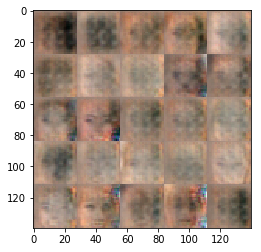

Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 1.7162
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 2.1618
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 4.0424
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 2.3506
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 2.2128
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.2616


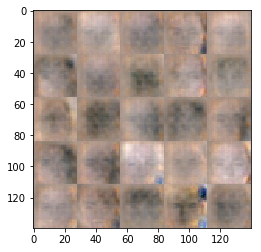

Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 2.4093
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.7020
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 2.3287


In [32]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.